<h1> AirBnB listings of the Minato Ward ANOVA and gradient boosting application</h1>
<h3>by Angelo Cortez</h3>

In [1]:
# Import our needed modules
# numpy and pandas to manipulate the csv's dataframe components
import numpy as np
import pandas as pd

In [4]:

tyo=pd.read_csv('C:\\Users\\Angelo\\Desktop\\pythonprojects\\scraper\\csvscraped\\ginza_try_2\\listings.csv')

In [5]:
tyo.dropna(axis=0, how='all', inplace=True)

In [6]:
# Then we import our listings file. We do not want to see blank rows, so we shall delete them with the .dropna method

tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

In [7]:
tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})
tyo.drop('room_type', axis=1, inplace = True)
tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)
tyo.drop('url', axis=1, inplace=True)

In [8]:
# we take care of dummy variables using this function, or we can use the .fillna further down below

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


In [9]:
tyo.drop('cancel_policy',axis=1, inplace=True)   

In [10]:
tyo.drop(0, axis=0, inplace=True)

# Set X and Y variables here. 

X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price


In [11]:
# Imputer - replaces the null values using a strategy and axis. 


from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)
X.isnull().sum().sort_values(ascending=False).head()
# We can see that there are no missing values

book_instantly        0
Entire_home/apt       0
satisfaction_guest    0
rev_count             0
response_rate         0
dtype: int64

C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[ 22.43590597  21.56735768  21.90442418  21.95544196  21.22523223
  23.7814173 ]


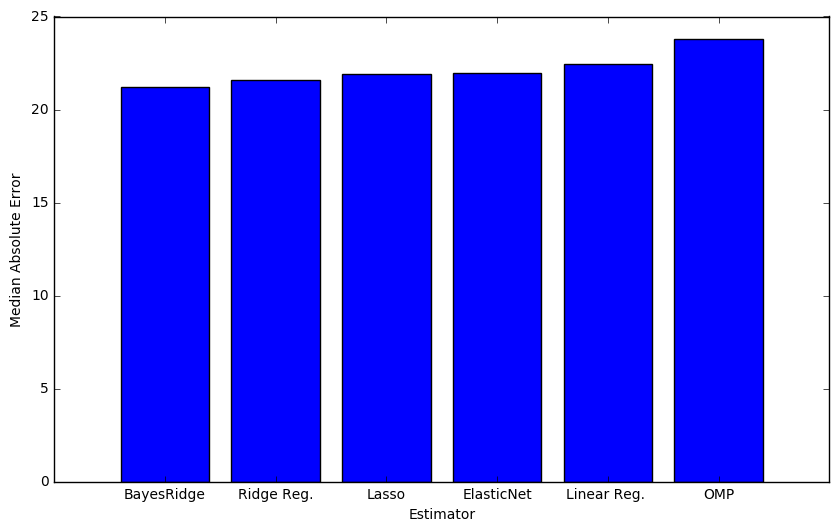

In [20]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations


from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y, test_size=0.2, random_state=20)




for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,6))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

In [27]:
# calculate median error using gradient boosting regression

n_est = 500


tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 3 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 4 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best
abs(clf.best_score_)


C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Angelo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users

15.838235916238052

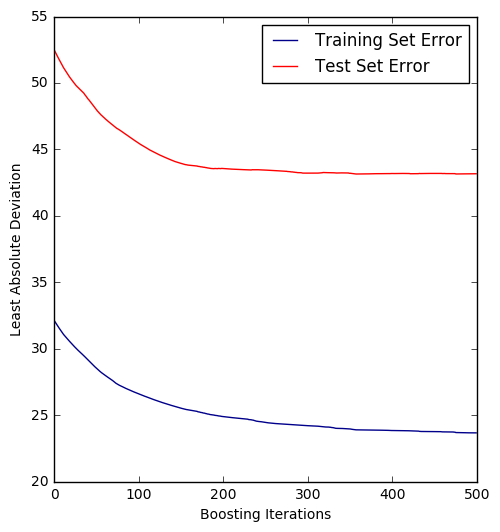

In [28]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

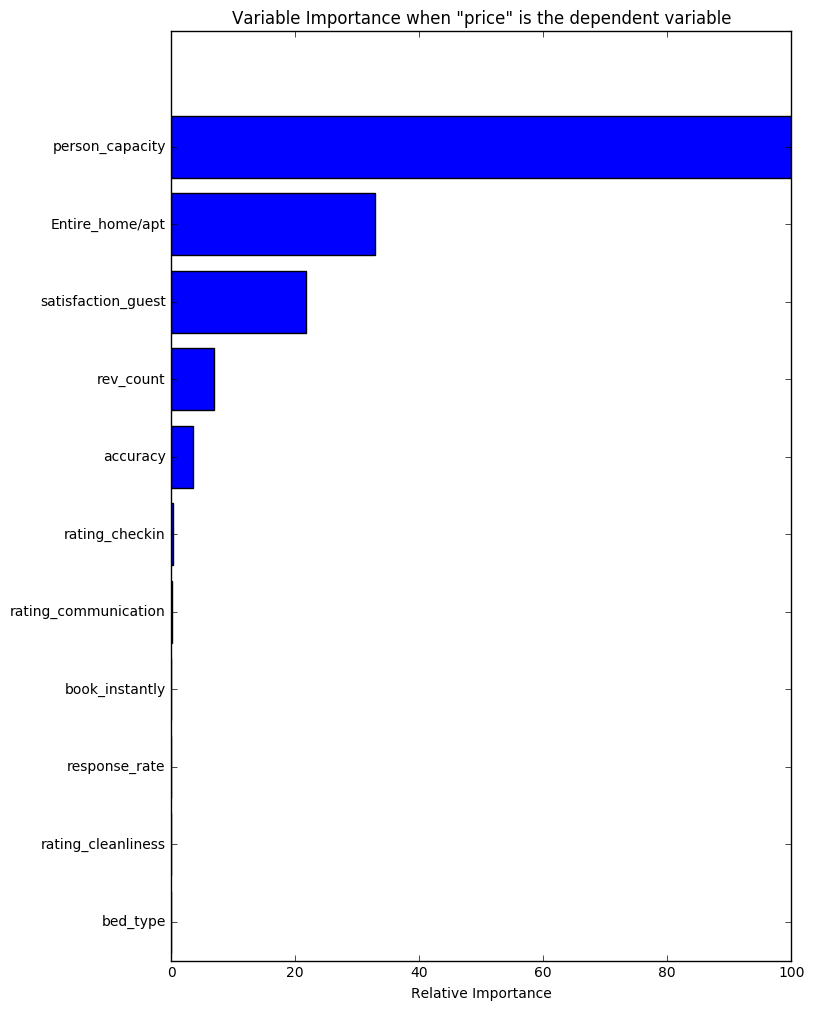

In [26]:

feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance when "price" is the dependent variable')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text xticklabel objects>)

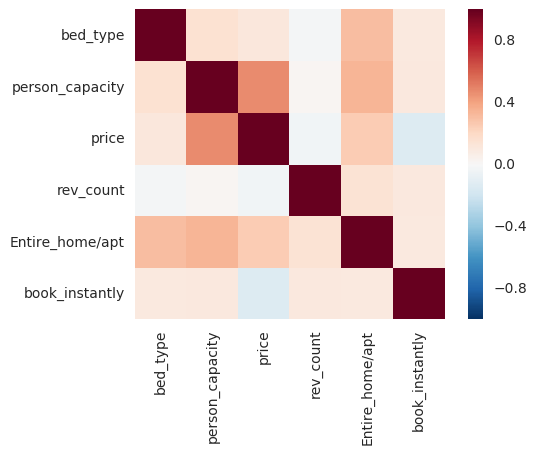

In [22]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables. 
# We can see that the most correlated to price is the person capacity of a listing. 

pears= X = tyo.drop(['amenities','response_time'], axis=1)
import seaborn as sns
%matplotlib inline
corr_matrix = pears.corr()
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

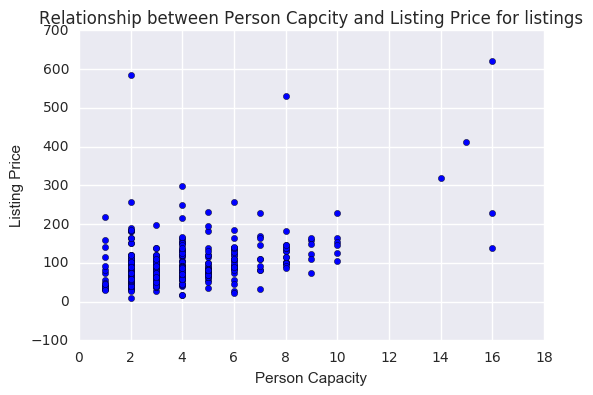

In [23]:
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capcity and Listing Price for listings")
plt.show()